<a href="https://colab.research.google.com/github/msasen/pytorch/blob/main/8_tabular_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import seaborn as sns

import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import SGD
from torch.nn import Sequential


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Veri Hazırla

In [10]:
df = pd.read_csv('/content/exit.csv')
a=df

In [22]:
del a["Unnamed: 0.1"]

In [24]:
X=a
del X["fare_amount"]

In [26]:
X.shape

(99800, 2)

In [42]:
YT = pd.read_csv("/content/exit.csv")
Y = pd.DataFrame()
Y["fare_amount"] = YT["fare_amount"]
Y

,fare_amount
0,12.5
1,31.5
2,11.7
3,7.0
4,5.3
...,...
99795,5.5
99796,9.0
99797,4.9
99798,12.1


In [ ]:
print(df.shape)

(569, 33)


In [ ]:
for i in (df.diagnosis):
  print(i)

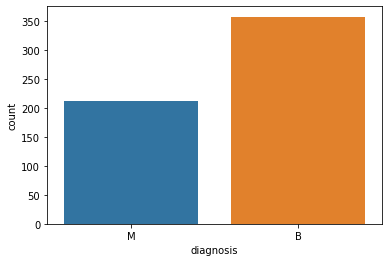

In [ ]:
ax = sns.countplot(x="diagnosis", data=df)

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-137-8868aeb8be65>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is 'M':


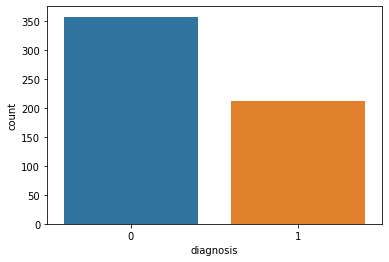

In [ ]:
def m_b_to_1_0(x):
  if x is 'M':
    return 1
  return 0
df.diagnosis = df.diagnosis.apply(m_b_to_1_0) #labeling malignant as 1 and benign as 0
ax = sns.countplot(x="diagnosis", data=df)


In [ ]:
X = df.iloc[:,2:-1]
print(X.shape)
X.values

(569, 30)


array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [ ]:
y = df.diagnosis
y.values


In [44]:
Y.shape,X.shape

((99800, 1), (99800, 2))

In [114]:
#imp1 startify = y kritik
X_train,X_test,y_train,y_test = train_test_split(X.values,Y.values,test_size=0.3)
X_val,X_test,y_val,y_test =  train_test_split(X_test,y_test,test_size=0.5) #we will use 70% of total data as training data, and rest 30% is equaly divided as test and validation data

In [116]:
scaler  = StandardScaler()
#imp2 train'e fit_transform val ve test'e transform ver

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Eğit

In [126]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [140]:
batch_size = 140000   
epochs = 90
learning_rate = 0.0001   
n_inputs = X_train.shape[1] 

In [141]:
# dataset definition
class TabularDataset(Dataset):
    # load the dataset
    def __init__(self, X,y):
        # store the inputs and outputs
        self.X = X
        self.y = y
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [142]:
train_dataset = TabularDataset(X_train,y_train)
val_dataset = TabularDataset(X_val,y_val)
test_dataset = TabularDataset(X_test,y_test)

print(X_val.shape)
print(X_test.shape)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False) # we will load entire validation set as a batch
test_dl = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False) #  will load entire test set as a batch

(14970, 2)
(14970, 2)


In [ ]:
NN = Sequential(nn.Linear(n_inputs, 10),
                nn.ReLU(),
                nn.Linear(10, 5),
                nn.ReLU(),
                nn.Linear(5,1),
                # nn.Sigmoid()
)
NN.to(device) # We will move the model to GPU, if its available

In [144]:
#BCELoss olasılık durumları içindir. Eğer iki class varsa 0 yada 1 kullanımı sağlıklıdır
#criterion = nn.BCELoss()
criterion = torch.nn.MSELoss()
optimizer = SGD(NN.parameters(), lr=learning_rate)

In [ ]:
train_loss = []
val_loss = []
val_accuracy = []
c=0
loss = nn.MSELoss()
for epoch in range(epochs):
  c=c+1
  train_loss_batch = []
  val_loss_batch = []
  for i, (inputs, targets) in enumerate(train_dl): # enumerate mini batches
      inputs, targets = inputs.to(device), targets.to(device) # move the data to GPU if available
      optimizer.zero_grad() # clear the gradients
      yhat = NN(inputs.float()) # compute the model output
      loss = criterion(yhat, targets.float()) # calculate loss
      train_loss_batch.append(loss.cpu().detach().numpy()) # store the loss back to cpu and credit assignment
      loss.backward() # update model weights
      optimizer.step()
  train_loss.append(sum(train_loss_batch)/i)
  #### EVALUATION ON VALIDATION SET ######################  if you are not using validation set, just skip the next lines
  for (inputs, targets) in val_dl:
      inputs, targets = inputs.to(device), targets.to(device) # move the data to GPU if available
      yhat = NN(inputs.float())
      loss = criterion(yhat, targets.float()) #calculate loss
      val_loss.append(loss.cpu().detach().numpy()) # store the loss back to cpu and credit assignment
      actual = targets.cpu().numpy() #to calculate the validation accuracy over an epoch
      actual = actual.reshape((len(actual), 1))
      yhat = yhat.cpu().detach().numpy()
      yhat = yhat.round() # round to class values
      print(c)
print("################### Training finished ##########################")

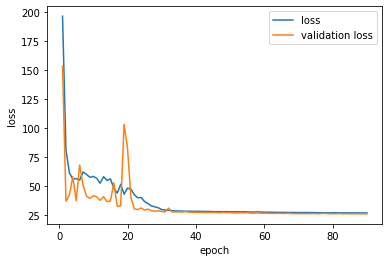

In [146]:
x = list(range(1,epochs+1))
plt.figure()
plt.plot(np.array(x),np.array(train_loss),label='loss')
plt.plot(np.array(x),np.array(val_loss),label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

ValueError: ignored

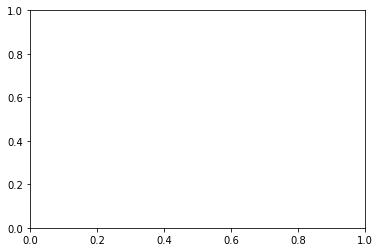

In [84]:
x = list(range(1,epochs+1))
plt.figure()
plt.plot(np.array(x),np.array(val_accuracy),label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
predictions, actuals = [], []
for i, (inputs, targets) in enumerate(train_dl):
    inputs,targets = inputs.to(device),targets.to(device)
    yhat = NN(inputs.float()) # evaluate the model on the train set (to get train accuracy)
    # retrieve numpy array
    yhat = yhat.cpu().detach().numpy()
    actual = targets.cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    # round to class values
    yhat = yhat.round()
    # store
    predictions.append(yhat)
    actuals.append(actual)
predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
acc = accuracy_score(actuals, predictions)
print("Train accuracy:",acc)


Train accuracy: 0.9849246231155779


In [ ]:
predictions, actuals = [], []
for (inputs, targets) in test_dl: 
    inputs,targets = inputs.to(device), targets.to(device)
    yhat = NN(inputs.float()) # evaluate the model on the test set
    yhat = yhat.cpu().detach().numpy() # retrieve numpy array
    actual = targets.cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.round() # round to class values
    predictions.append(yhat) # store
    actuals.append(actual)
predictions, actuals = np.vstack(predictions), np.vstack(actuals)
acc = accuracy_score(actuals, predictions) # calculate accuracy
print("Test accuracy:",acc)

Test accuracy: 0.9767441860465116
